<a href="https://colab.research.google.com/github/Akhilesh-K-Yadav/Meta-Learning_Projects/blob/main/Prototypical_Net/ProtoNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os
import glob

import google_drive_downloader as gdd
import imageio
import numpy as np
import torch
from sklearn.metrics import accuracy_score
from torch.utils.data import dataset, sampler, dataloader
from torch import nn
import torch.nn.functional as F
from torch import autograd
import matplotlib.pyplot as plt
from torch.utils import tensorboard
#import pdb

NUM_TRAIN_CLASSES = 1100
NUM_VAL_CLASSES = 100
NUM_TEST_CLASSES = 423
NUM_SAMPLES_PER_CLASS = 20

NUM_INPUT_CHANNELS = 1
NUM_HIDDEN_CHANNELS = 64
KERNEL_SIZE = 3
NUM_CONV_LAYERS = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SUMMARY_INTERVAL = 10
SAVE_INTERVAL = 100
PRINT_INTERVAL = 10
VAL_INTERVAL = PRINT_INTERVAL * 5
NUM_TEST_TASKS = 600


In [2]:
BASE_PATH = './omniglot_resized'
GDD_FILE_ID = '1iaSFXIYC3AB8q9K_M-oVMa4pmB7yKMtI'
gdd.GoogleDriveDownloader.download_file_from_google_drive(
                file_id=GDD_FILE_ID,
                dest_path=f'{BASE_PATH}.zip',
                unzip=True
            )

Unzipping...Done.


In [3]:
def load_image(file_path):
    """Loads and transforms an Omniglot image.
    Args:
        file_path (str): file path of image
    Returns:
        a Tensor containing image data
            shape (1, 28, 28)
    """
    x = imageio.imread(file_path)
    x = torch.tensor(x, dtype=torch.float32).reshape([1, 28, 28])
    x = x / 255.0
    return 1 - x

In [4]:
class OmniglotDataset(dataset.Dataset):
    """Omniglot dataset for meta-learning.

    Each element of the dataset is a task. A task is specified with a key,
    which is a tuple of class indices (no particular order). The corresponding
    value is the instantiated task, which consists of sampled (image, label)
    pairs.
    """

    def __init__(self, num_support, num_query):
        """Inits OmniglotDataset.

        Args:
            num_support (int): number of support examples per class
            num_query (int): number of query examples per class
        """
        super().__init__()

        # get all character folders
        self._character_folders = glob.glob(
            os.path.join(BASE_PATH, '*/*/'))
        assert len(self._character_folders) == (
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES + NUM_TEST_CLASSES
        )

        # shuffle characters
        np.random.default_rng(0).shuffle(self._character_folders)

        # check problem arguments
        assert num_support + num_query <= NUM_SAMPLES_PER_CLASS
        self._num_support = num_support
        self._num_query = num_query

    def __getitem__(self, class_idxs):
        """Constructs a task.

        Data for each class is sampled uniformly at random without replacement.
        The ordering of the labels corresponds to that of class_idxs.

        Args:
            class_idxs (tuple[int]): class indices that comprise the task

        Returns:
            images_support (Tensor): task support images
                shape (num_way * num_support, channels, height, width)
            labels_support (Tensor): task support labels
                shape (num_way * num_support,)
            images_query (Tensor): task query images
                shape (num_way * num_query, channels, height, width)
            labels_query (Tensor): task query labels
                shape (num_way * num_query,)
        """
        images_support, images_query = [], []
        labels_support, labels_query = [], []

        for label, class_idx in enumerate(class_idxs):
            # get a class's examples and sample from them
            all_file_paths = glob.glob(
                os.path.join(self._character_folders[class_idx], '*.png')
            )
            sampled_file_paths = np.random.default_rng().choice(
                all_file_paths,
                size=self._num_support + self._num_query,
                replace=False
            )
            images = [load_image(file_path) for file_path in sampled_file_paths]

            # split sampled examples into support and query
            images_support.extend(images[:self._num_support])
            images_query.extend(images[self._num_support:])
            labels_support.extend([label] * self._num_support)
            labels_query.extend([label] * self._num_query)

        # aggregate into tensors
        images_support = torch.stack(images_support)  # shape (N*S, C, H, W)
        labels_support = torch.tensor(labels_support)  # shape (N*S)
        images_query = torch.stack(images_query)
        labels_query = torch.tensor(labels_query)

        return images_support, labels_support, images_query, labels_query


In [5]:
class OmniglotSampler(sampler.Sampler):
    """Samples task specification keys for an OmniglotDataset."""

    def __init__(self, split_idxs, num_way, num_tasks):

      """Inits OmniglotSampler.

      Args:
          split_idxs (range): indices that comprise the
              training/validation/test split
          num_way (int): number of classes per task
          num_tasks (int): number of tasks to sample
      """
      super().__init__(None)

      self.split_idxs = split_idxs
      self.num_way = num_way
      self.num_tasks = num_tasks

    def __iter__(self):
      return (
          np.random.default_rng().choice(
              self.split_idxs,
              size=self.num_way,
              replace=False
          ) for _ in range(self.num_tasks)
      )

    def __len__(self):
        return self.num_tasks

In [6]:
def identity(x):
    return x

def get_omniglot_dataloader(
        split,
        batch_size,
        num_way,
        num_support,
        num_query,
        num_tasks_per_epoch
):
    """Returns a dataloader.DataLoader for Omniglot.

    Args:
        split (str): one of 'train', 'val', 'test'
        batch_size (int): number of tasks per batch
        num_way (int): number of classes per task
        num_support (int): number of support examples per class
        num_query (int): number of query examples per class
        num_tasks_per_epoch (int): number of tasks before DataLoader is
            exhausted
    """

    if split == 'train':
        split_idxs = range(NUM_TRAIN_CLASSES)
    elif split == 'val':
        split_idxs = range(
            NUM_TRAIN_CLASSES,
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES
        )
    elif split == 'test':
        split_idxs = range(
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES,
            NUM_TRAIN_CLASSES + NUM_VAL_CLASSES + NUM_TEST_CLASSES
        )
    else:
        raise ValueError

    return dataloader.DataLoader(
        dataset=OmniglotDataset(num_support, num_query),
        batch_size=batch_size,
        sampler=OmniglotSampler(split_idxs, num_way, num_tasks_per_epoch),
        num_workers=2,
        collate_fn=identity,
        pin_memory=torch.cuda.is_available(),
        drop_last=True
    )

In [7]:
image = imageio.imread("/content/omniglot_resized/Alphabet_of_the_Magi/character01/0709_01.png")
image.shape

<ipython-input-7-913cf8e1afe4>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread("/content/omniglot_resized/Alphabet_of_the_Magi/character01/0709_01.png")


(28, 28)

In [8]:
samples = get_omniglot_dataloader(
        split='train',
        batch_size=1,
        num_way=4,
        num_support=1,
        num_query=1,
        num_tasks_per_epoch=1
)
tasks = next(iter(samples))
for task in tasks:
  images_support, labels_support, images_query, labels_query = task
images_support.shape, labels_support.shape, images_query.shape, labels_query.shape

<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


(torch.Size([4, 1, 28, 28]),
 torch.Size([4]),
 torch.Size([4, 1, 28, 28]),
 torch.Size([4]))

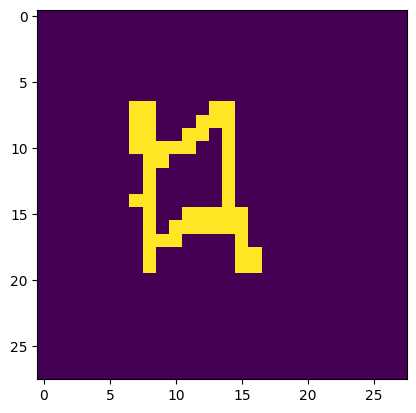

In [9]:
plt.imshow(images_support[0][0])

In [10]:
labels_support

tensor([0, 1, 2, 3])

In [11]:
def score(logits, labels):
    """Returns the mean accuracy of a model's predictions on a set of examples.

    Args:
        logits (torch.Tensor): model predicted logits
            shape (examples, classes)
        labels (torch.Tensor): classification labels from 0 to num_classes - 1
            shape (examples,)
    """


    assert logits.dim() == 2
    assert labels.dim() == 1
    assert logits.shape[0] == labels.shape[0]
    y = torch.argmax(logits, dim=-1) == labels
    y = y.type(torch.float)
    return torch.mean(y).item()

In [12]:
class ProtoNetNetwork(nn.Module):
    """Container for ProtoNet weights and image-to-latent computation."""

    def __init__(self):
        """Inits ProtoNetNetwork.

        The network consists of four convolutional blocks, each comprising a
        convolution layer, a batch normalization layer, ReLU activation, and 2x2
        max pooling for downsampling. There is an additional flattening
        operation at the end.

        Note that unlike conventional use, batch normalization is always done
        with batch statistics, regardless of whether we are training or
        evaluating. This technically makes meta-learning transductive, as
        opposed to inductive.
        """
        super().__init__()
        layers = []
        in_channels = NUM_INPUT_CHANNELS
        for _ in range(NUM_CONV_LAYERS):
            layers.append(
                nn.Conv2d(
                    in_channels,
                    NUM_HIDDEN_CHANNELS,
                    (KERNEL_SIZE, KERNEL_SIZE),
                    padding='same'
                )
            )
            layers.append(nn.BatchNorm2d(NUM_HIDDEN_CHANNELS))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            in_channels = NUM_HIDDEN_CHANNELS
        layers.append(nn.Flatten())
        self._layers = nn.Sequential(*layers)
        self.to(DEVICE)

    def forward(self, images):
        """Computes the latent representation of a batch of images.

        Args:
            images (Tensor): batch of Omniglot images
                shape (num_images, channels, height, width)

        Returns:
            a Tensor containing a batch of latent representations
                shape (num_images, latents)
        """
        return self._layers(images)


In [17]:
class ProtoNet:
    """Trains and assesses a prototypical network."""

    def __init__(self, learning_rate, log_dir):
        """Inits ProtoNet.

        Args:
            learning_rate (float): learning rate for the Adam optimizer
            log_dir (str): path to logging directory
        """

        self._network = ProtoNetNetwork()
        self._optimizer = torch.optim.Adam(
            self._network.parameters(),
            lr=learning_rate
        )
        self._log_dir = log_dir
        os.makedirs(self._log_dir, exist_ok=True)

        self._start_train_step = 0

    def _step(self, task_batch):
        """Computes ProtoNet mean loss (and accuracy) on a batch of tasks.

        Args:
            task_batch (tuple[Tensor, Tensor, Tensor, Tensor]):
                batch of tasks from an Omniglot DataLoader

        Returns:
            a Tensor containing mean ProtoNet loss over the batch
                shape ()
            mean support set accuracy over the batch as a float
            mean query set accuracy over the batch as a float
        """

        loss_batch = []
        accuracy_support_batch = []
        accuracy_query_batch = []
        for task in task_batch:
            images_support, labels_support, images_query, labels_query = task
            images_support = images_support.to(DEVICE)
            labels_support = labels_support.to(DEVICE)
            images_query = images_query.to(DEVICE)
            labels_query = labels_query.to(DEVICE)
            # For a given task, compute the prototypes and the protonet loss.
            # F.cross_entropy to compute classification losses.
            # score to compute accuracies.
            # Populate loss_batch, accuracy_support_batch, and
            # accuracy_query_batch.

            # we need to compute all of the prototypes for all classes in the task training batch
            supp_feats = self._network(images_support)

            # get all classes, and then score
            classes = torch.unique(labels_support, sorted=True)
            means = []
            for c in classes:
                idxes = (labels_support == c).nonzero()
                class_feats = supp_feats[idxes]
                prototype = torch.mean(class_feats, dim=0)
                means.append(prototype)

            means = torch.cat(means)  # (num_classes, feature_dim)

            # now to measure distances to all means
            # (batch_size, feature_dim)
            query_feats = self._network(images_query)
            # (batch_size, num_classes, feature_dim)
            query_feats = torch.stack([query_feats] * means.size(0), dim=1)

            exp_means = means.expand(*query_feats.shape)

            # (batch_size, num_classes, feature_dim)
            query_diffs = query_feats - exp_means
            # (batch_size, num_classes)
            query_sq_norms = torch.norm(query_diffs, p=2, dim=-1).square()
            query_logits = -query_sq_norms
            # query_norms[i][j] = d(f_\theta(x_i), c_j)

            loss = F.cross_entropy(query_logits, labels_query)
            loss_batch.append(loss)

            # compute accuracies
            query_acc =  score(query_logits, labels_query)
            accuracy_query_batch.append(query_acc)

            # (batch_size, num_classes, feature_dim)
            supp_feats = torch.stack([supp_feats] * means.size(0), dim=1)

            exp_means = means.expand(*supp_feats.shape)

            # (batch_size, num_classes, feature_dim)
            supp_diffs = supp_feats - exp_means
            # (batch_size, num_classes)
            supp_sq_norms = torch.norm(supp_diffs, p=2, dim=2).square()
            supp_logits = -supp_sq_norms
            supp_acc =  score(supp_logits, labels_support)
            accuracy_support_batch.append(supp_acc)


        return (
            torch.mean(torch.stack(loss_batch)),
            np.mean(accuracy_support_batch),
            np.mean(accuracy_query_batch)
        )

    def train(self, dataloader_train, dataloader_val, writer):
        """Train the ProtoNet.

        Consumes dataloader_train to optimize weights of ProtoNetNetwork
        while periodically validating on dataloader_val, logging metrics, and
        saving checkpoints.

        Args:
            dataloader_train (DataLoader): loader for train tasks
            dataloader_val (DataLoader): loader for validation tasks
            writer (SummaryWriter): TensorBoard logger
        """
        print(f'Starting training at iteration {self._start_train_step}.')
        for i_step, task_batch in enumerate(
                dataloader_train,
                start=self._start_train_step
        ):
            self._optimizer.zero_grad()
            loss, accuracy_support, accuracy_query = self._step(task_batch)
            loss.backward()
            self._optimizer.step()

            if i_step % PRINT_INTERVAL == 0:
                print(
                    f'Iteration {i_step}: '
                    f'loss: {loss.item():.3f}, '
                    f'support accuracy: {accuracy_support.item():.3f}, '
                    f'query accuracy: {accuracy_query.item():.3f}'
                )
                writer.add_scalar('loss/train', loss.item(), i_step)
                writer.add_scalar(
                    'train_accuracy/support',
                    accuracy_support.item(),
                    i_step
                )
                writer.add_scalar(
                    'train_accuracy/query',
                    accuracy_query.item(),
                    i_step
                )

            if i_step % VAL_INTERVAL == 0:
                with torch.no_grad():
                    losses, accuracies_support, accuracies_query = [], [], []
                    for val_task_batch in dataloader_val:
                        loss, accuracy_support, accuracy_query = (
                            self._step(val_task_batch)
                        )
                        losses.append(loss.item())
                        accuracies_support.append(accuracy_support)
                        accuracies_query.append(accuracy_query)
                    loss = np.mean(losses)
                    accuracy_support = np.mean(accuracies_support)
                    accuracy_query = np.mean(accuracies_query)
                print(
                    f'Validation: '
                    f'loss: {loss:.3f}, '
                    f'support accuracy: {accuracy_support:.3f}, '
                    f'query accuracy: {accuracy_query:.3f}'
                )
                writer.add_scalar('loss/val', loss, i_step)
                writer.add_scalar(
                    'val_accuracy/support',
                    accuracy_support,
                    i_step
                )
                writer.add_scalar(
                    'val_accuracy/query',
                    accuracy_query,
                    i_step
                )

            if i_step % SAVE_INTERVAL == 0:
                self._save(i_step)

    def test(self, dataloader_test):
        """Evaluate the ProtoNet on test tasks.

        Args:
            dataloader_test (DataLoader): loader for test tasks
        """
        accuracies = []
        for task_batch in dataloader_test:
            accuracies.append(self._step(task_batch)[2])
        mean = np.mean(accuracies)
        std = np.std(accuracies)
        mean_95_confidence_interval = 1.96 * std / np.sqrt(NUM_TEST_TASKS)
        print(
            f'Accuracy over {NUM_TEST_TASKS} test tasks: '
            f'mean {mean:.3f}, '
            f'95% confidence interval {mean_95_confidence_interval:.3f}'
        )

    def load(self, checkpoint_step):
        """Loads a checkpoint.

        Args:
            checkpoint_step (int): iteration of checkpoint to load

        Raises:
            ValueError: if checkpoint for checkpoint_step is not found
        """
        target_path = (
            f'{os.path.join(self._log_dir, "state")}'
            f'{checkpoint_step}.pt'
        )
        if os.path.isfile(target_path):
            state = torch.load(target_path)
            self._network.load_state_dict(state['network_state_dict'])
            self._optimizer.load_state_dict(state['optimizer_state_dict'])
            self._start_train_step = checkpoint_step + 1
            print(f'Loaded checkpoint iteration {checkpoint_step}.')
        else:
            raise ValueError(
                f'No checkpoint for iteration {checkpoint_step} found.'
            )

    def _save(self, checkpoint_step):
        """Saves network and optimizer state_dicts as a checkpoint.

        Args:
            checkpoint_step (int): iteration to label checkpoint with
        """
        torch.save(
            dict(network_state_dict=self._network.state_dict(),
                 optimizer_state_dict=self._optimizer.state_dict()),
            f'{os.path.join(self._log_dir, "state")}{checkpoint_step}.pt'
        )
        print('Saved checkpoint.')


In [14]:
def main():
    log_dir = None
    num_way = 5
    num_support = 2
    num_query = 3
    learning_rate = 0.001
    batch_size = 5
    num_train_iterations = 10000
    test = False
    checkpoint_step = -1

    if log_dir is None:
        log_dir = f'./logs/protonet/omniglot.way:{ num_way}.support:{ num_support}.query:{ num_query}.lr:{ learning_rate}.batch_size:{ batch_size}'
    print(f'log_dir: {log_dir}')
    writer = tensorboard.SummaryWriter(log_dir=log_dir)

    protonet = ProtoNet( learning_rate, log_dir)

    if  checkpoint_step > -1:
        protonet.load( checkpoint_step)
    else:
        print('Checkpoint loading skipped.')

    if not  test:
        num_training_tasks =  batch_size * ( num_train_iterations -
                                                 checkpoint_step - 1)
        print(
            f'Training on tasks with composition '
            f'num_way={ num_way}, '
            f'num_support={ num_support}, '
            f'num_query={ num_query}'
        )
        dataloader_train = get_omniglot_dataloader(
            'train',
            batch_size,
            num_way,
            num_support,
            num_query,
            num_training_tasks
        )
        dataloader_val = get_omniglot_dataloader(
            'val',
            batch_size,
            num_way,
            num_support,
            num_query,
            batch_size * 4
        )
        protonet.train(
            dataloader_train,
            dataloader_val,
            writer
        )
    else:
        print(
            f'Testing on tasks with composition '
            f'num_way={ num_way}, '
            f'num_support={num_support}, '
            f'num_query={num_query}'
        )
        dataloader_test = get_omniglot_dataloader(
            'test',
            1,
            num_way,
            num_support,
            num_query,
            NUM_TEST_TASKS
        )
        protonet.test(dataloader_test)

In [19]:
main()

log_dir: ./logs/protonet/omniglot.way:5.support:2.query:3.lr:0.001.batch_size:5
Checkpoint loading skipped.
Training on tasks with composition num_way=5, num_support=2, num_query=3
Starting training at iteration 0.


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Iteration 0: loss: 1.607, support accuracy: 0.980, query accuracy: 0.680


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 1.605, support accuracy: 0.995, query accuracy: 0.687
Saved checkpoint.
Iteration 10: loss: 1.297, support accuracy: 1.000, query accuracy: 0.773
Iteration 20: loss: 1.043, support accuracy: 0.900, query accuracy: 0.600
Iteration 30: loss: 0.820, support accuracy: 0.960, query accuracy: 0.693
Iteration 40: loss: 0.823, support accuracy: 0.980, query accuracy: 0.653
Iteration 50: loss: 0.802, support accuracy: 0.940, query accuracy: 0.667


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.675, support accuracy: 0.980, query accuracy: 0.753
Iteration 60: loss: 0.695, support accuracy: 1.000, query accuracy: 0.800
Iteration 70: loss: 0.844, support accuracy: 1.000, query accuracy: 0.733
Iteration 80: loss: 0.663, support accuracy: 0.960, query accuracy: 0.707
Iteration 90: loss: 0.565, support accuracy: 0.980, query accuracy: 0.787
Iteration 100: loss: 0.540, support accuracy: 1.000, query accuracy: 0.827


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.530, support accuracy: 0.970, query accuracy: 0.813
Saved checkpoint.
Iteration 110: loss: 0.607, support accuracy: 0.940, query accuracy: 0.787
Iteration 120: loss: 0.562, support accuracy: 1.000, query accuracy: 0.853
Iteration 130: loss: 0.735, support accuracy: 1.000, query accuracy: 0.747
Iteration 140: loss: 0.473, support accuracy: 1.000, query accuracy: 0.827
Iteration 150: loss: 0.734, support accuracy: 0.980, query accuracy: 0.707


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.586, support accuracy: 0.985, query accuracy: 0.793
Iteration 160: loss: 0.287, support accuracy: 1.000, query accuracy: 0.880
Iteration 170: loss: 0.520, support accuracy: 1.000, query accuracy: 0.827
Iteration 180: loss: 0.784, support accuracy: 1.000, query accuracy: 0.840
Iteration 190: loss: 0.847, support accuracy: 0.960, query accuracy: 0.720
Iteration 200: loss: 0.687, support accuracy: 0.980, query accuracy: 0.773


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.522, support accuracy: 1.000, query accuracy: 0.823
Saved checkpoint.
Iteration 210: loss: 0.473, support accuracy: 1.000, query accuracy: 0.827
Iteration 220: loss: 0.491, support accuracy: 0.980, query accuracy: 0.787
Iteration 230: loss: 0.606, support accuracy: 0.940, query accuracy: 0.813
Iteration 240: loss: 0.473, support accuracy: 1.000, query accuracy: 0.827
Iteration 250: loss: 0.930, support accuracy: 1.000, query accuracy: 0.840


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.507, support accuracy: 0.990, query accuracy: 0.813
Iteration 260: loss: 0.858, support accuracy: 0.980, query accuracy: 0.720
Iteration 270: loss: 0.439, support accuracy: 0.980, query accuracy: 0.827
Iteration 280: loss: 0.548, support accuracy: 1.000, query accuracy: 0.813
Iteration 290: loss: 0.310, support accuracy: 0.980, query accuracy: 0.907
Iteration 300: loss: 0.525, support accuracy: 1.000, query accuracy: 0.867


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.419, support accuracy: 1.000, query accuracy: 0.867
Saved checkpoint.
Iteration 310: loss: 0.357, support accuracy: 0.980, query accuracy: 0.853
Iteration 320: loss: 0.668, support accuracy: 0.980, query accuracy: 0.760
Iteration 330: loss: 0.449, support accuracy: 1.000, query accuracy: 0.813
Iteration 340: loss: 0.664, support accuracy: 0.980, query accuracy: 0.773
Iteration 350: loss: 0.580, support accuracy: 0.980, query accuracy: 0.760


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.555, support accuracy: 0.990, query accuracy: 0.837
Iteration 360: loss: 0.546, support accuracy: 0.960, query accuracy: 0.813
Iteration 370: loss: 0.372, support accuracy: 1.000, query accuracy: 0.880
Iteration 380: loss: 0.309, support accuracy: 1.000, query accuracy: 0.907
Iteration 390: loss: 0.361, support accuracy: 1.000, query accuracy: 0.813
Iteration 400: loss: 0.505, support accuracy: 1.000, query accuracy: 0.840


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.357, support accuracy: 0.990, query accuracy: 0.863
Saved checkpoint.
Iteration 410: loss: 1.104, support accuracy: 0.980, query accuracy: 0.760
Iteration 420: loss: 0.363, support accuracy: 0.980, query accuracy: 0.880
Iteration 430: loss: 0.368, support accuracy: 1.000, query accuracy: 0.840
Iteration 440: loss: 0.439, support accuracy: 1.000, query accuracy: 0.867
Iteration 450: loss: 0.353, support accuracy: 1.000, query accuracy: 0.867


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.303, support accuracy: 0.990, query accuracy: 0.907
Iteration 460: loss: 0.349, support accuracy: 1.000, query accuracy: 0.880
Iteration 470: loss: 0.130, support accuracy: 1.000, query accuracy: 0.960
Iteration 480: loss: 0.323, support accuracy: 1.000, query accuracy: 0.853
Iteration 490: loss: 0.290, support accuracy: 1.000, query accuracy: 0.893
Iteration 500: loss: 0.511, support accuracy: 1.000, query accuracy: 0.827


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.328, support accuracy: 1.000, query accuracy: 0.877
Saved checkpoint.
Iteration 510: loss: 0.693, support accuracy: 1.000, query accuracy: 0.707
Iteration 520: loss: 0.582, support accuracy: 0.980, query accuracy: 0.827
Iteration 530: loss: 0.378, support accuracy: 1.000, query accuracy: 0.880
Iteration 540: loss: 0.328, support accuracy: 1.000, query accuracy: 0.867
Iteration 550: loss: 0.483, support accuracy: 1.000, query accuracy: 0.800


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.394, support accuracy: 0.995, query accuracy: 0.890
Iteration 560: loss: 0.332, support accuracy: 1.000, query accuracy: 0.853
Iteration 570: loss: 0.548, support accuracy: 0.980, query accuracy: 0.773
Iteration 580: loss: 0.317, support accuracy: 1.000, query accuracy: 0.907
Iteration 590: loss: 0.281, support accuracy: 1.000, query accuracy: 0.933
Iteration 600: loss: 0.436, support accuracy: 1.000, query accuracy: 0.853


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.425, support accuracy: 0.995, query accuracy: 0.837
Saved checkpoint.
Iteration 610: loss: 0.510, support accuracy: 0.980, query accuracy: 0.853
Iteration 620: loss: 0.304, support accuracy: 1.000, query accuracy: 0.880
Iteration 630: loss: 0.226, support accuracy: 1.000, query accuracy: 0.947
Iteration 640: loss: 0.498, support accuracy: 0.980, query accuracy: 0.867
Iteration 650: loss: 0.368, support accuracy: 1.000, query accuracy: 0.867


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.396, support accuracy: 1.000, query accuracy: 0.853
Iteration 660: loss: 0.216, support accuracy: 1.000, query accuracy: 0.973
Iteration 670: loss: 0.381, support accuracy: 1.000, query accuracy: 0.840
Iteration 680: loss: 0.412, support accuracy: 1.000, query accuracy: 0.880
Iteration 690: loss: 0.409, support accuracy: 1.000, query accuracy: 0.867
Iteration 700: loss: 0.285, support accuracy: 0.980, query accuracy: 0.920


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.283, support accuracy: 1.000, query accuracy: 0.907
Saved checkpoint.
Iteration 710: loss: 0.332, support accuracy: 1.000, query accuracy: 0.893
Iteration 720: loss: 0.171, support accuracy: 1.000, query accuracy: 0.920
Iteration 730: loss: 0.387, support accuracy: 1.000, query accuracy: 0.867
Iteration 740: loss: 0.426, support accuracy: 1.000, query accuracy: 0.800
Iteration 750: loss: 0.693, support accuracy: 1.000, query accuracy: 0.827


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.353, support accuracy: 0.995, query accuracy: 0.887
Iteration 760: loss: 0.464, support accuracy: 1.000, query accuracy: 0.813
Iteration 770: loss: 0.317, support accuracy: 1.000, query accuracy: 0.893
Iteration 780: loss: 0.382, support accuracy: 1.000, query accuracy: 0.867
Iteration 790: loss: 0.199, support accuracy: 1.000, query accuracy: 0.893
Iteration 800: loss: 0.224, support accuracy: 0.980, query accuracy: 0.893


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.387, support accuracy: 0.990, query accuracy: 0.883
Saved checkpoint.
Iteration 810: loss: 0.151, support accuracy: 1.000, query accuracy: 0.973
Iteration 820: loss: 0.329, support accuracy: 1.000, query accuracy: 0.867
Iteration 830: loss: 0.382, support accuracy: 1.000, query accuracy: 0.880
Iteration 840: loss: 0.323, support accuracy: 1.000, query accuracy: 0.880
Iteration 850: loss: 0.343, support accuracy: 1.000, query accuracy: 0.867


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.250, support accuracy: 0.995, query accuracy: 0.897
Iteration 860: loss: 0.285, support accuracy: 1.000, query accuracy: 0.907
Iteration 870: loss: 0.307, support accuracy: 0.960, query accuracy: 0.920
Iteration 880: loss: 0.193, support accuracy: 1.000, query accuracy: 0.933
Iteration 890: loss: 0.289, support accuracy: 1.000, query accuracy: 0.880
Iteration 900: loss: 0.209, support accuracy: 1.000, query accuracy: 0.920


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.335, support accuracy: 1.000, query accuracy: 0.883
Saved checkpoint.
Iteration 910: loss: 0.296, support accuracy: 1.000, query accuracy: 0.853
Iteration 920: loss: 0.311, support accuracy: 1.000, query accuracy: 0.933
Iteration 930: loss: 0.167, support accuracy: 0.980, query accuracy: 0.960
Iteration 940: loss: 0.205, support accuracy: 1.000, query accuracy: 0.960
Iteration 950: loss: 0.178, support accuracy: 1.000, query accuracy: 0.960


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.210, support accuracy: 0.995, query accuracy: 0.927
Iteration 960: loss: 0.157, support accuracy: 1.000, query accuracy: 0.960
Iteration 970: loss: 0.116, support accuracy: 1.000, query accuracy: 0.987
Iteration 980: loss: 0.526, support accuracy: 1.000, query accuracy: 0.853
Iteration 990: loss: 0.166, support accuracy: 1.000, query accuracy: 0.933
Iteration 1000: loss: 0.177, support accuracy: 1.000, query accuracy: 0.933


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.273, support accuracy: 1.000, query accuracy: 0.903
Saved checkpoint.
Iteration 1010: loss: 0.190, support accuracy: 1.000, query accuracy: 0.933
Iteration 1020: loss: 0.196, support accuracy: 1.000, query accuracy: 0.947
Iteration 1030: loss: 0.207, support accuracy: 1.000, query accuracy: 0.920
Iteration 1040: loss: 0.189, support accuracy: 1.000, query accuracy: 0.933
Iteration 1050: loss: 0.096, support accuracy: 1.000, query accuracy: 0.987


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.221, support accuracy: 1.000, query accuracy: 0.923
Iteration 1060: loss: 0.429, support accuracy: 1.000, query accuracy: 0.853
Iteration 1070: loss: 0.196, support accuracy: 1.000, query accuracy: 0.933
Iteration 1080: loss: 0.112, support accuracy: 1.000, query accuracy: 0.960
Iteration 1090: loss: 0.249, support accuracy: 1.000, query accuracy: 0.893
Iteration 1100: loss: 0.201, support accuracy: 1.000, query accuracy: 0.907


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.205, support accuracy: 1.000, query accuracy: 0.927
Saved checkpoint.
Iteration 1110: loss: 0.120, support accuracy: 1.000, query accuracy: 0.973
Iteration 1120: loss: 0.118, support accuracy: 1.000, query accuracy: 0.973
Iteration 1130: loss: 0.071, support accuracy: 1.000, query accuracy: 0.960
Iteration 1140: loss: 0.146, support accuracy: 1.000, query accuracy: 0.947
Iteration 1150: loss: 0.137, support accuracy: 1.000, query accuracy: 0.920


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.110, support accuracy: 0.995, query accuracy: 0.970
Iteration 1160: loss: 0.168, support accuracy: 1.000, query accuracy: 0.947
Iteration 1170: loss: 0.109, support accuracy: 1.000, query accuracy: 0.947
Iteration 1180: loss: 0.297, support accuracy: 0.980, query accuracy: 0.880
Iteration 1190: loss: 0.113, support accuracy: 1.000, query accuracy: 0.960
Iteration 1200: loss: 0.422, support accuracy: 0.980, query accuracy: 0.907


<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)
<ipython-input-3-a6327f0e4a5e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  x = imageio.imread(file_path)


Validation: loss: 0.111, support accuracy: 1.000, query accuracy: 0.950
Saved checkpoint.
Iteration 1210: loss: 0.231, support accuracy: 1.000, query accuracy: 0.907
Iteration 1220: loss: 0.213, support accuracy: 1.000, query accuracy: 0.933
Iteration 1230: loss: 0.110, support accuracy: 1.000, query accuracy: 0.987


KeyboardInterrupt: ignored